# Лабораторная работа 1. Интерполяция Лагранжа и кусочная интерполяция.

## Импорт библиотек и описание необходимых функций и переменных.

Импорт:

In [317]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import derivative

Общие параметры:

In [337]:
interval_start = -5.
interval_end = 5.
plot_nodes_count = 200

nodes_left_boundary = 4
nodes_right_boundary = 21

figsize_standart = (8, 6)
dpi_standart = 100
linewidth_standart = 1.0
bbox_to_anchor_standart = (1.05, 1)
cmap_name_standart = 'winter'

Функция для нахождения i-го базисного полинома Лагранжа:

In [319]:
def l_i(i, x, x_nodes):
    li = 1
    
    for j in range(len(x_nodes)):
        if j != (i - 1):
            li *= (x - x_nodes[j]) / (x_nodes[i - 1] - x_nodes[j])
    return li

Функция для нахождения интерполяционного полинома Лагранжа

In [320]:
def L(x, x_nodes, y_nodes):
    Lx = 0
    
    for i in range(len(x_nodes)):
        Lx += y_nodes[i] * l_i(i + 1, x, x_nodes)
    return Lx

Функция для кусочно-линейной интерполяции:

In [395]:
def f_piece_lin(x, x_nodes, y_nodes):
    for i in range(1, len(x_nodes)):
        if (x_nodes[i - 1] <= x <= x_nodes[i]):
            a0 = (y_nodes[i] - y_nodes[i - 1]) / (x_nodes[i] - x_nodes[i - 1])
            a1 = y_nodes[i - 1] - a0 * x_nodes[i - 1]

            return (a0 * x_nodes[i - 1] + a1)
        
    return None

Заданная функция:

In [322]:
def f(x):
    return np.exp(-x**2)

Вспомогательная функция для пересчета значений оптимальных узлов на произвольном отрезке:

In [323]:
def translate_to_interval(x, start, end):
    return 0.5 * ( (end - start) * x + start + end )

Вспомогательная функция для нахождения производной функции:

In [324]:
def nth_derivative(f, n, x):
    if (n % 2 == 0):
        derivative_order = n + 1
    else:
        derivative_order = n + 2
        
    nth_derivative = derivative(f, x, n=n, order=derivative_order)
    
    return nth_derivative

Вспомогательная функция для нахождения оптимальных узлов:

In [344]:
def cheb_nodes(start, end, n):
    x_cheb = np.array([])
    
    for k in range(n):
        x_cheb = np.append(x_cheb,
                  translate_to_interval(
                    np.cos( (2 * (k + 1) - 1) * np.pi / (2 * n) ),
                    start, end))
    return x_cheb

Функция для нахождения остаточного члена в случае равномерно распределенных узлов:

In [360]:
def rem_evenly(x, x_nodes):
    rem_evenly = 0
    n = len(x_nodes)
    x_len = len(x)
    
    if 0 not in x:
        x = np.append(x, 0)
        
    nth_derivative_vec = np.vectorize(nth_derivative, excluded=['f', 'n'])
    derivatives_array = np.abs(nth_derivative(f=f, n=n, x=x))
    
    mult_array = np.array([])
    for i in range(x_len):
        mult = 1
        for j in range(n):
            mult *= (x[i] - x_nodes[j])
        mult_array = np.append(mult_array, np.abs(mult))
        
    rem_evenly = (np.max(derivatives_array) / np.math.factorial(n)) * np.max(mult_array)
        
    return rem_evenly

Функция для нахождения остаточного члена в случае равномерно оптимально узлов:

In [374]:
def rem_cheb(x, x_nodes):
    n = len(x_nodes)
    
    nth_derivative_vec = np.vectorize(nth_derivative, excluded=['f', 'n'])
    derivatives_array = nth_derivative(f=f, n=n, x=x)
    
    rem_cheb = np.max(derivatives_array) / ( 2**(n - 1) * (np.math.factorial(n)))
    
    return rem_cheb

Функция для нахождения остаточного члена в случае кусочно-линейной интерполяции:

In [328]:
def rem_piece_lin(x, x_nodes):
    n = len(x_nodes)
    
    h = ( interval_start - interval_end ) / (n - 1)
    
    rem_piece_lin = (np.e * h**2) / 8 
        
    return rem_piece_lin

Общие параметры и векторизация необходимых функций:

In [387]:
f_vec = np.vectorize(f)
L_vec = np.vectorize(L, excluded=['x_nodes', 'y_nodes'])
f_piece_lin_vec = np.vectorize(f_piece_lin, excluded=['x_nodes', 'y_nodes'])

x = np.linspace(interval_start, interval_end, nodes_count)
fx_vec = f_vec(x)
N = np.arange(nodes_left_boundary, nodes_right_boundary)

## Случай равномерно распределенных узлов.

### Построение графиков заданной функции и интерполяционного полинома Лагранжа.

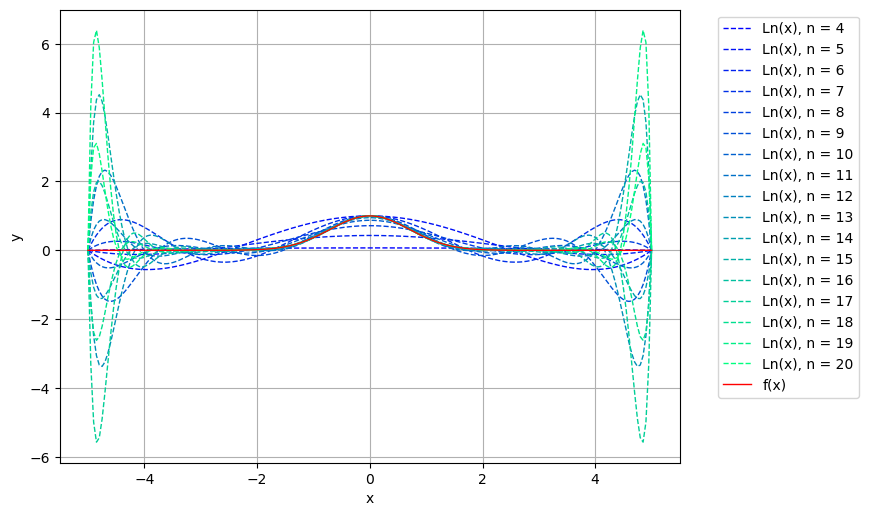

In [371]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figsize_standart, dpi=dpi_standart)
cmap = plt.cm.get_cmap(cmap_name_standart, len(N))

for n in N:
    x_nodes_evenly_distributed = np.linspace(interval_start, interval_end, n)
    y_nodes_evenly_distributed = f(x_nodes_evenly_distributed)
    
    axes.plot(x, L(x, x_nodes_evenly_distributed, y_nodes_evenly_distributed),
              color=cmap(n - nodes_left_boundary), linestyle='--',
              linewidth=linewidth_standart, label='Ln(x), n = {}'.format(n))
    
axes.plot(x, fx, color="red", linewidth=linewidth_standart, label='f(x)')
axes.grid()

axes.legend(bbox_to_anchor=bbox_to_anchor_standart, loc='upper left')
axes.set_xlabel("x")
axes.set_ylabel("y")

plt.show()

### Нахождение расстояния между заданной функцией и полученным интерполяционным полиномом в лебеговом пространстве.

In [353]:
dist_evenly_array = np.array([])

for n in N:
    x_nodes_evenly_distributed = np.linspace(interval_start, interval_end, n)
    y_nodes_evenly_distributed = f(x_nodes_evenly_distributed)
    
    distance = np.max(np.abs(fx_vec - L_vec(x=x, x_nodes=x_nodes_evenly_distributed,
                                        y_nodes=y_nodes_evenly_distributed)))

    dist_evenly_array = np.append(dist_evenly_array, distance)
                       
    print("Количество узлов = {} , расстояние = {}".format(n, distance))

Количество узлов = 4 , расстояние = 0.9294220788474536
Количество узлов = 5 , расстояние = 0.5600542274100669
Количество узлов = 6 , расстояние = 0.5683253948585647
Количество узлов = 7 , расстояние = 0.8908330341061284
Количество узлов = 8 , расстояние = 0.2837229914568502
Количество узлов = 9 , расстояние = 1.4846701970687846
Количество узлов = 10 , расстояние = 0.5115106812959587
Количество узлов = 11 , расстояние = 2.329393725056922
Количество узлов = 12 , расстояние = 0.8915128269338115
Количество узлов = 13 , расстояние = 3.3733850294241576
Количество узлов = 14 , расстояние = 1.4033005137346821
Количество узлов = 15 , расстояние = 4.523860399730428
Количество узлов = 16 , расстояние = 2.003337276144759
Количество узлов = 17 , расстояние = 5.574609161153755
Количество узлов = 18 , расстояние = 2.617247888918776
Количество узлов = 19 , расстояние = 6.393134128936814
Количество узлов = 20 , расстояние = 3.105716396876675


### Оценка верхней границы зависимости погрешности интерполяции от количества узлов.

In [362]:
rem_evenly_array = np.array([])

for n in N:
    x_nodes_evenly_distributed = np.linspace(interval_start, interval_end, n)
    
    rem_evenly_current = rem_evenly(x, x_nodes_evenly_distributed)
    rem_evenly_array = np.append(rem_evenly_array, rem_evenly_current)
    
    print("Количество узлов = {} , остаточный член = {}".format(n, rem_evenly_current))

Количество узлов = 4 , остаточный член = 15.9114943842406
Количество узлов = 5 , остаточный член = 5.428851403807068
Количество узлов = 6 , остаточный член = 13.787813606011465
Количество узлов = 7 , остаточный член = 3.2718067151766212
Количество узлов = 8 , остаточный член = 8.216661089519748
Количество узлов = 9 , остаточный член = 1.3945537558210634
Количество узлов = 10 , остаточный член = 3.4427468036005373
Количество узлов = 11 , остаточный член = 0.43719269877386474
Количество узлов = 12 , остаточный член = 1.0672930028255991
Количество узлов = 13 , остаточный член = 0.10393841188435068
Количество узлов = 14 , остаточный член = 0.25137172209127395
Количество узлов = 15 , остаточный член = 0.019987822635055046
Количество узлов = 16 , остаточный член = 0.04604979634834832
Количество узлов = 17 , остаточный член = 0.0031121858083663673
Количество узлов = 18 , остаточный член = 0.006942170267885833
Количество узлов = 19 , остаточный член = 0.0003946317660017291
Количество узлов = 2

### Сравнение полученных расстояния и верхней границы зависимости.

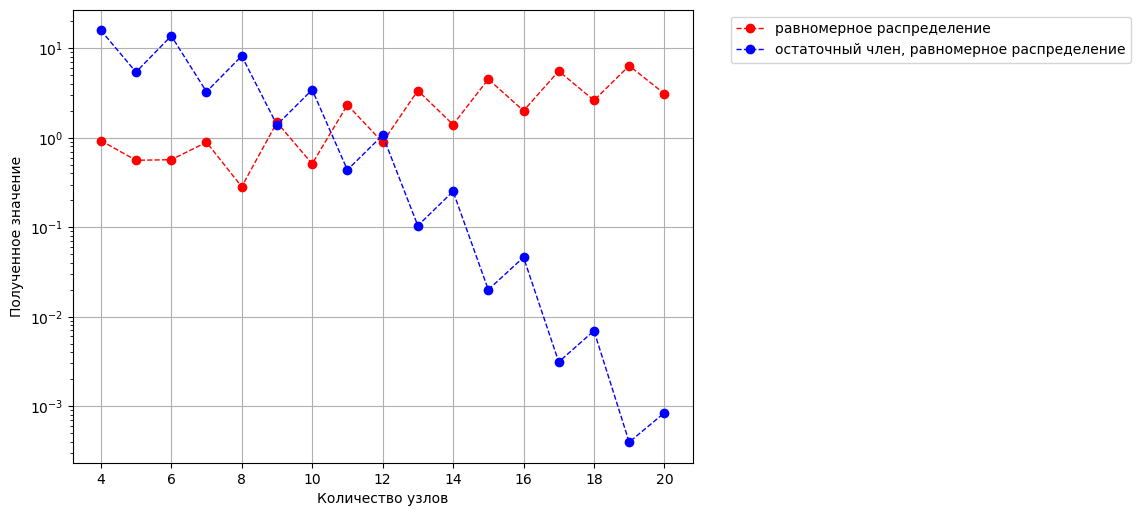

In [365]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figsize_standart, dpi=dpi_standart)

axes.semilogy(N, dist_evenly_array, '--o', color="red",
              linewidth=linewidth_standart, label="равномерное распределение")
axes.semilogy(N, rem_evenly_array, '--o', color="blue",
              linewidth=linewidth_standart, label="остаточный член, равномерное распределение")
axes.grid()

axes.legend(bbox_to_anchor=bbox_to_anchor_standart, loc='upper left')
axes.set_xlabel("Количество узлов")
axes.set_ylabel("Полученное значение")

plt.show()

## Случай оптимально распределенных узлов.

### Построение графиков заданной функции и интерполяционного полинома Лагранжа.

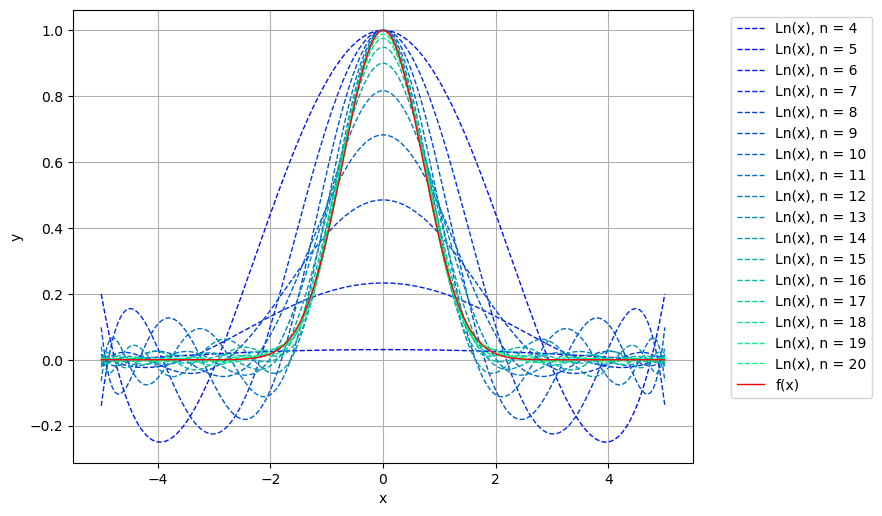

In [375]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figsize_standart, dpi=dpi_standart)
cmap = plt.cm.get_cmap(cmap_name_standart, len(N))

for n in N:
    x_nodes_cheb = cheb_nodes(interval_start, interval_end, n)
    y_nodes_cheb = f(x_nodes_cheb)
    
    axes.plot(x, L(x, x_nodes_cheb, y_nodes_cheb),
              color=cmap(n - nodes_left_boundary), linestyle='--',
              linewidth=linewidth_standart, label='Ln(x), n = {}'.format(n))
    
axes.plot(x, fx, color="red", linewidth=linewidth_standart, label='f(x)')
axes.grid()

axes.legend(bbox_to_anchor=bbox_to_anchor_standart, loc='upper left')
axes.set_xlabel("x")
axes.set_ylabel("y")

plt.show()

### Нахождение расстояния между заданной функцией и полученным интерполяционным полиномом в лебеговом пространстве.

In [376]:
dist_cheb_array = np.array([])

for n in N:
    x_nodes_cheb = cheb_nodes(interval_start, interval_end, n)
    y_nodes_cheb = f(x_nodes_cheb)
    
    distance = np.max(np.abs(fx_vec - L_vec(x=x, x_nodes=x_nodes_cheb,
                                        y_nodes=y_nodes_cheb)))
    dist_cheb_array = np.append(dist_cheb_array, distance)
    
    print("Количество узлов = {} , расстояние = {}".format(n, distance))

Количество узлов = 4 , расстояние = 0.9683441027456798
Количество узлов = 5 , расстояние = 0.565053480919778
Количество узлов = 6 , расстояние = 0.7662996714044655
Количество узлов = 7 , расстояние = 0.3581262679083945
Количество узлов = 8 , расстояние = 0.514267396653969
Количество узлов = 9 , расстояние = 0.19970330717074608
Количество узлов = 10 , расстояние = 0.3169068681695911
Количество узлов = 11 , расстояние = 0.1252371491449286
Количество узлов = 12 , расстояние = 0.18307230405671393
Количество узлов = 13 , расстояние = 0.07278655961218285
Количество узлов = 14 , расстояние = 0.09947396926953878
Количество узлов = 15 , расстояние = 0.03726198661245251
Количество узлов = 16 , расстояние = 0.05089457106388173
Количество узлов = 17 , расстояние = 0.018623961261578087
Количество узлов = 18 , расстояние = 0.024548672575833708
Количество узлов = 19 , расстояние = 0.008690706768055414
Количество узлов = 20 , расстояние = 0.011178767930954736


### Оценка верхней границы зависимости погрешности интерполяции от количества узлов.

In [378]:
rem_cheb_array = np.array([])

for n in N:
    x_nodes_cheb = cheb_nodes(interval_start, interval_end, n)
    
    rem_cheb_current = rem_cheb(x, x_nodes_cheb)
    rem_cheb_array = np.append(rem_cheb_array, rem_cheb_current)
    
    print("Количество узлов = {} , остаточный член = {}".format(n, rem_cheb_current))

Количество узлов = 4 , остаточный член = 0.01608392776342978
Количество узлов = 5 , остаточный член = 0.0009569772719325531
Количество узлов = 6 , остаточный член = 0.00028888501142948497
Количество узлов = 7 , остаточный член = 1.4940395628471411e-05
Количество узлов = 8 , остаточный член = 5.765505344007165e-06
Количество узлов = 9 , остаточный член = 1.4872132030298956e-07
Количество узлов = 10 , остаточный член = 4.494614226070034e-08
Количество узлов = 11 , остаточный член = 1.02672462056303e-09
Количество узлов = 12 , остаточный член = 3.6543083136897913e-10
Количество узлов = 13 , остаточный член = 5.2167602180119465e-12
Количество узлов = 14 , остаточный член = 1.5692061719919403e-12
Количество узлов = 15 , остаточный член = 2.0788466490686087e-14
Количество узлов = 16 , остаточный член = 6.9035150167066816e-15
Количество узлов = 17 , остаточный член = 6.617713488084566e-17
Количество узлов = 18 , остаточный член = 1.8735940838117998e-17
Количество узлов = 19 , остаточный член 

### Сравнение полученных расстояния и верхней границы зависимости.

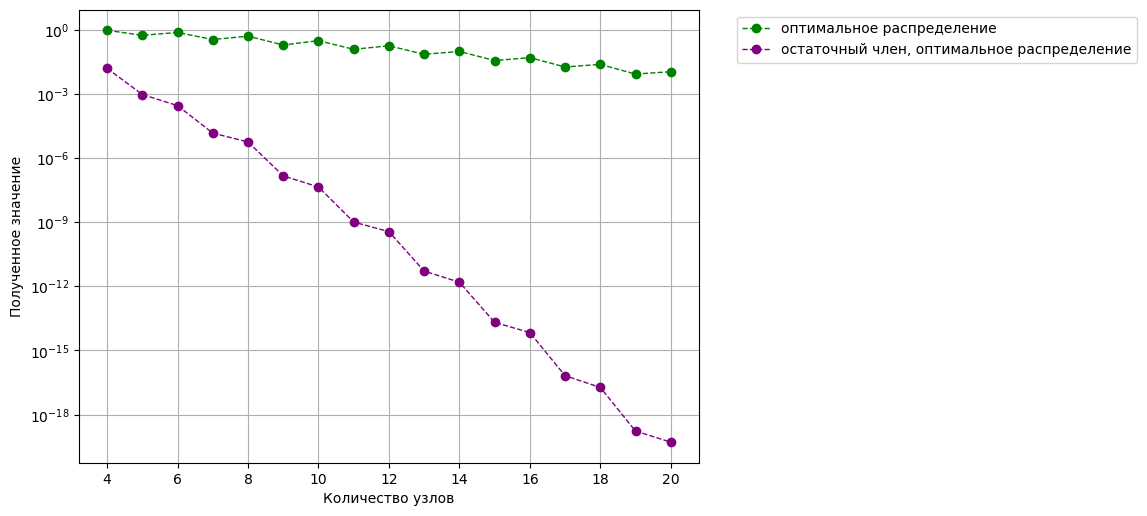

In [381]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figsize_standart, dpi=dpi_standart)

axes.semilogy(N, dist_cheb_array, '--o', color="green",
              linewidth=linewidth_standart, label="оптимальное распределение")
axes.semilogy(N, rem_cheb_array, '--o', color="purple",
              linewidth=linewidth_standart, label="остаточный член, оптимальное распределение")
axes.grid()

axes.legend(bbox_to_anchor=bbox_to_anchor_standart, loc='upper left')
axes.set_xlabel("Количество узлов")
axes.set_ylabel("Полученное значение")

plt.show()

## Случай кусочно-линейной интерполяции.

### Построение графиков заданной функции и интерполяционного полинома Лагранжа.

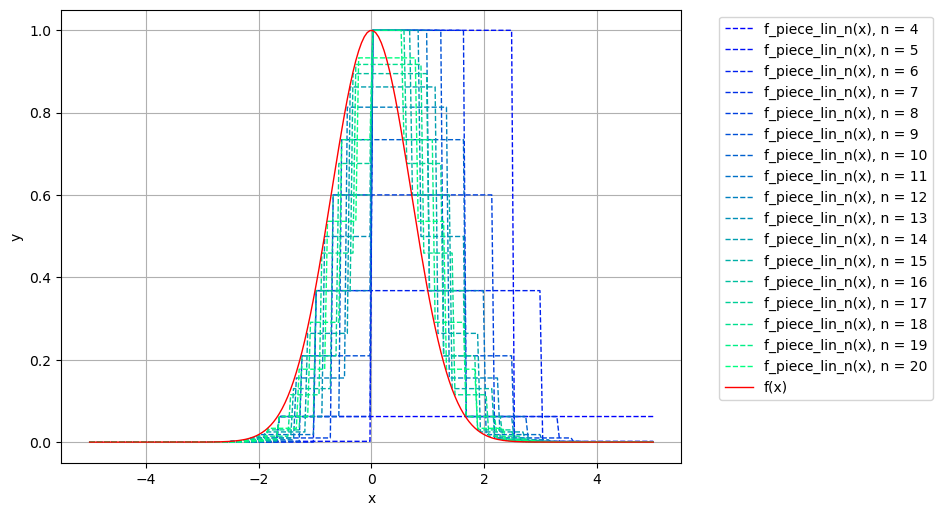

In [396]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figsize_standart, dpi=dpi_standart)

cmap = plt.cm.get_cmap(cmap_name_standart, len(N))

for n in N:
    x_nodes_evenly_distributed = np.linspace(interval_start, interval_end, n)
    y_nodes_evenly_distributed = f(x_nodes_evenly_distributed)
    
    f_piece_lin_array = f_piece_lin_vec(x=x, x_nodes=x_nodes_evenly_distributed,
                                        y_nodes=y_nodes_evenly_distributed)

    axes.plot(x, f_piece_lin_array,
              color=cmap(n - nodes_left_boundary), linestyle='--',
              linewidth=linewidth_standart, label='f_piece_lin_n(x), n = {}'.format(n))


axes.plot(x, fx, color="red", linewidth=linewidth_standart, label='f(x)')
axes.grid()

axes.legend(bbox_to_anchor=bbox_to_anchor_standart, loc='upper left')
axes.set_xlabel("x")
axes.set_ylabel("y")

plt.show()

### Нахождение расстояния между заданной функцией и полученным интерполяционным полиномом в лебеговом пространстве.

In [399]:
dist_piece_lin_array = np.array([])

for n in N:
    x_nodes_evenly_distributed = np.linspace(interval_start, interval_end, n)
    y_nodes_evenly_distributed = f(x_nodes_evenly_distributed)
    
    distance = np.max(np.abs(fx_vec - f_piece_lin_vec(x=x, x_nodes=x_nodes_evenly_distributed,
                                        y_nodes=y_nodes_evenly_distributed)))
    
    dist_piece_lin_array = np.append(dist_piece_lin_array, distance)
    
    print("Количество узлов = {} , расстояние = {}".format(n, distance))

Количество узлов = 4 , расстояние = 0.9371923780145636
Количество узлов = 5 , расстояние = 0.9979447211646681
Количество узлов = 6 , расстояние = 0.6314894608652376
Количество узлов = 7 , расстояние = 0.9371923780145636
Количество узлов = 8 , расстояние = 0.5899227161284659
Количество узлов = 9 , расстояние = 0.7897575148855821
Количество узлов = 10 , расстояние = 0.6649993954647574
Количество узлов = 11 , расстояние = 0.6314894608652376
Количество узлов = 12 , расстояние = 0.6435660396626778
Количество узлов = 13 , расстояние = 0.5000171134374035
Количество узлов = 14 , расстояние = 0.5840033801611619
Количество узлов = 15 , расстояние = 0.45814054319513875
Количество узлов = 16 , расстояние = 0.5120241598441335
Количество узлов = 17 , расстояние = 0.4643646354923775
Количество узлов = 18 , расстояние = 0.4556611690714472
Количество узлов = 19 , расстояние = 0.4251246777338088
Количество узлов = 20 , расстояние = 0.3902687048809589


### Оценка верхней границы зависимости погрешности интерполяции от количества узлов.

In [401]:
rem_piece_lin_array = np.array([])

for n in N:
    x_nodes_evenly_distributed = np.linspace(interval_start, interval_end, n)
    
    rem_piece_lin_current = rem_cheb(x, x_nodes_evenly_distributed)
    rem_piece_lin_array = np.append(rem_piece_lin_array, rem_piece_lin_current)
    
    print("Количество узлов = {} , остаточный член = {}".format(n, rem_piece_lin_current))

Количество узлов = 4 , остаточный член = 0.01608392776342978
Количество узлов = 5 , остаточный член = 0.0009569772719325531
Количество узлов = 6 , остаточный член = 0.00028888501142948497
Количество узлов = 7 , остаточный член = 1.4940395628471411e-05
Количество узлов = 8 , остаточный член = 5.765505344007165e-06
Количество узлов = 9 , остаточный член = 1.4872132030298956e-07
Количество узлов = 10 , остаточный член = 4.494614226070034e-08
Количество узлов = 11 , остаточный член = 1.02672462056303e-09
Количество узлов = 12 , остаточный член = 3.6543083136897913e-10
Количество узлов = 13 , остаточный член = 5.2167602180119465e-12
Количество узлов = 14 , остаточный член = 1.5692061719919403e-12
Количество узлов = 15 , остаточный член = 2.0788466490686087e-14
Количество узлов = 16 , остаточный член = 6.9035150167066816e-15
Количество узлов = 17 , остаточный член = 6.617713488084566e-17
Количество узлов = 18 , остаточный член = 1.8735940838117998e-17
Количество узлов = 19 , остаточный член 

### Сравнение полученных расстояния и верхней границы зависимости.

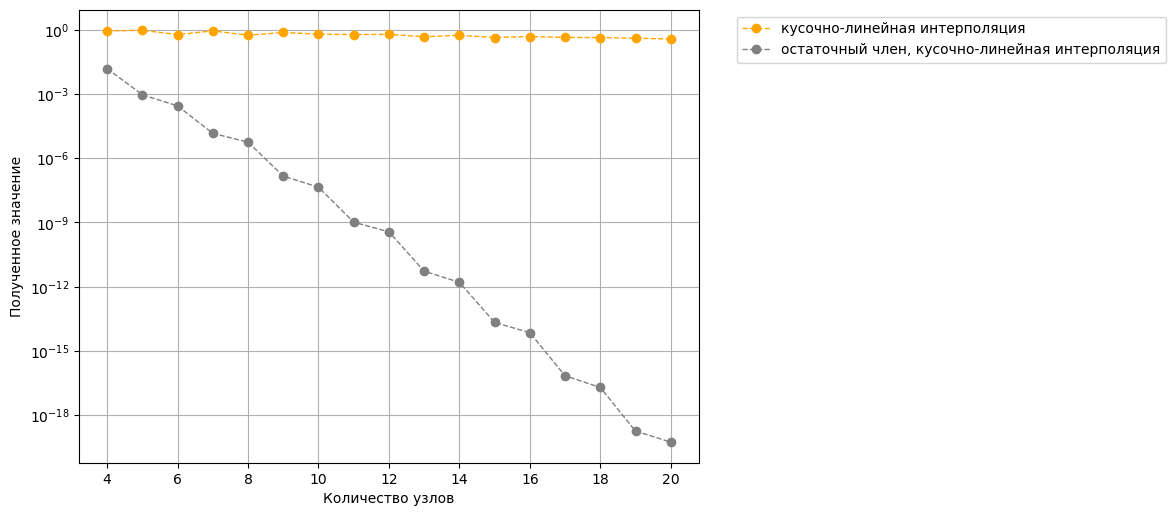

In [402]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figsize_standart, dpi=dpi_standart)
axes.semilogy(N, dist_piece_lin_array, '--o', color="orange",
              linewidth=linewidth_standart, label="кусочно-линейная интерполяция")
axes.semilogy(N, rem_piece_lin_array, '--o', color="grey",
              linewidth=linewidth_standart, label="остаточный член, кусочно-линейная интерполяция")
axes.grid()

axes.legend(bbox_to_anchor=bbox_to_anchor_standart, loc='upper left')
axes.set_xlabel("Количество узлов")
axes.set_ylabel("Полученное значение")

plt.show()

## Вывод зависимости расстояния в лебеговом пространстве от количества узлов для трех случаев интерполяции.

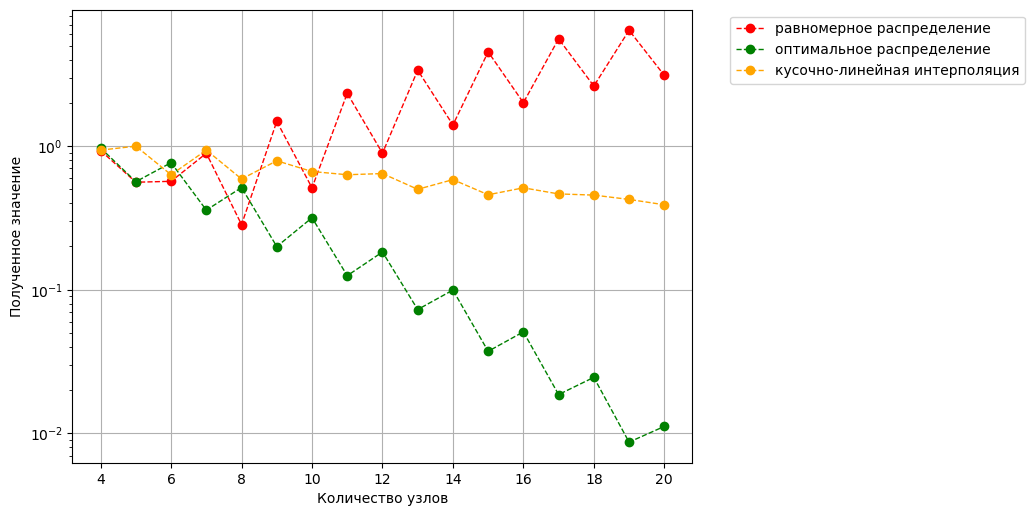

In [404]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figsize_standart, dpi=dpi_standart)

axes.semilogy(N, dist_evenly_array, '--o', color="red",
              linewidth=linewidth_standart, label="равномерное распределение")
axes.semilogy(N, dist_cheb_array, '--o', color="green",
              linewidth=linewidth_standart, label="оптимальное распределение")
axes.semilogy(N, dist_piece_lin_array, '--o', color="orange",
              linewidth=linewidth_standart, label="кусочно-линейная интерполяция")

axes.grid()

axes.legend(bbox_to_anchor=bbox_to_anchor_standart, loc='upper left')
axes.set_xlabel("Количество узлов")
axes.set_ylabel("Полученное значение")

plt.show()

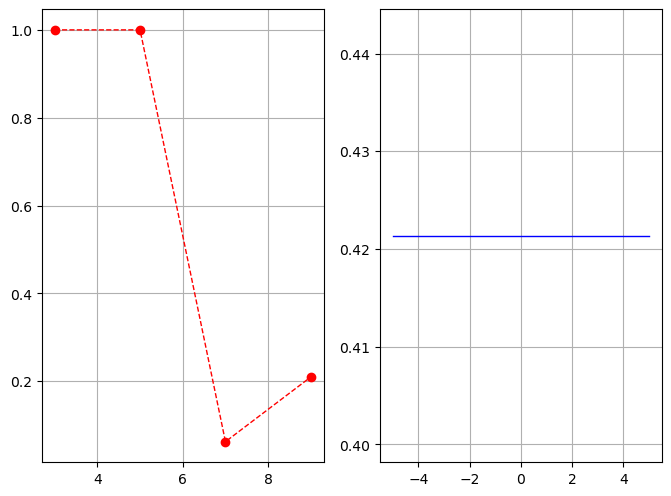

In [308]:
def f_err(x):
    f_lambda = lambda t: np.exp(-t**2)
    
    integral, accuracy = integrate.quad(f_lambda, 0, 1)
    return (1 / np.sqrt(np.pi)) * integral

N = [3, 5, 7, 9]
f_kus_lin_func = []
f_err_func = []

for n in N:
    x_nodes_evenly_distributed = np.linspace(-5., 5., n)
    f_kus_lin_func.append(f_kus_lin(2., x_nodes_evenly_distributed, f(x_nodes_evenly_distributed)))
    
for i in range(len(x)):
    f_err_func.append(f_err(x[i]))
    
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 6), dpi=100)

axes[0].plot(N, f_kus_lin_func, '--o', color="red", linewidth=1.0)
axes[1].plot(x, f_err_func, color="blue", linewidth=1.0)

axes[0].grid()
axes[1].grid()

plt.show()